### Import data science / machine learning libraries

In [2]:
# data science and preprocessing
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from PIL import Image
import os
import io
import ipywidgets as widgets
from PIL import Image
from IPython.display import display,clear_output
import warnings
warnings.filterwarnings('ignore')

# transfer learning
import cv2
import keras
from keras.applications.vgg16 import preprocess_input
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,Dropout,GlobalAveragePooling2D,Flatten,Input
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from keras.preprocessing import image
from tensorflow.keras.models import load_model

# k means
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# evaluation
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

### Load dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# function to load data without cropping
def load_data(train=True, directory="/content/drive/MyDrive/archive"):
  if train:
    directory += "/Training/*"
  else:
    directory += "/Testing/*"
  
  X = []
  y = []
  for folder in glob(directory):
    label = folder.split("/")[-1]
    for file in tqdm(glob(folder + '/*')):
      # resize image to fit in vgg16
      image = cv2.resize(cv2.imread(file), (224, 224))
      X.append(image)
      y.append(label)
  
  return np.array(X), np.array(y)

# load data with cropping
def load_data_crop(train=True, directory="/content/drive/MyDrive/archive"):
  if train:
    directory += "/train_0_new.npz"
  else:
    directory += "/test_0_new.npz"
  data = np.load(directory)
  X = []
  for img in data['X']:
    X.append(cv2.resize(img, (224, 224)))
  return np.array(X), data['y']

# convert label to integer
def encode_class(x):
  if x == 'no_tumor':
    return 0
  if x == "glioma_tumor":
    return 1
  if x == "meningioma_tumor":
    return 2
  if x == "pituitary_tumor":
    return 3

# inverse function
def int_to_label(x):
  if x == 0:
    return 'no_tumor'
  if x == 1:
    return "glioma_tumor"
  if x == 2:
    return "meningioma_tumor"
  if x == 3:
    return "pituitary_tumor"

# store labels
labels = ['no_tumor', 'glioma_tumo', 'meningioma_tumor', 'pituitary_tumor']

# input dimensions
H, W = 224, 224

### EfficientNet

#### Without cropping

In [6]:
## load data
X_train, y_train = load_data(train=True)
X_test, y_test = load_data(train=False)

100%|██████████| 100/100 [00:01<00:00, 63.03it/s]


In [7]:
y_train = np.array([encode_class(y) for y in y_train])
y_train = tf.keras.utils.to_categorical(y_train)
y_test = np.array([encode_class(y) for y in y_test])
y_test = tf.keras.utils.to_categorical(y_test)

In [8]:
## define efficientnet model

eff_model = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(H,W,3)) 
# we are not including the output layer of efficientnet

model = eff_model.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4, activation="softmax")(model)
model = tf.keras.models.Model(inputs=eff_model.input, outputs=model)

16705208/16705208 [==============================] - 0s 0us/step


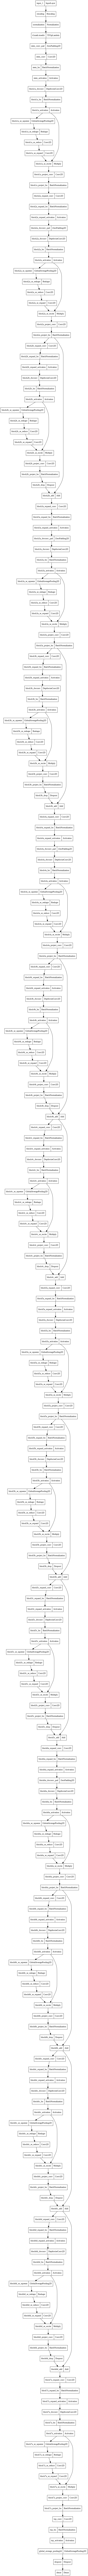

In [9]:
### model architecture
plot_model(model)

In [10]:
## compile efficientnet model
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [11]:
## fit model on training set
history1 = model.fit(X_train,y_train,validation_split=0.1, 
                      epochs =20, verbose=1, batch_size=32)

Epoch 1/20
81/81 [==============================] - 41s 305ms/step - loss: 0.3440 - accuracy: 0.8773 - val_loss: 0.6470 - val_accuracy: 0.8056
Epoch 2/20
81/81 [==============================] - 23s 288ms/step - loss: 0.1364 - accuracy: 0.9549 - val_loss: 0.6408 - val_accuracy: 0.8472
Epoch 3/20
81/81 [==============================] - 24s 298ms/step - loss: 0.1127 - accuracy: 0.9630 - val_loss: 0.4250 - val_accuracy: 0.8646
Epoch 4/20
81/81 [==============================] - 24s 301ms/step - loss: 0.0717 - accuracy: 0.9761 - val_loss: 0.7947 - val_accuracy: 0.7604
Epoch 5/20
81/81 [==============================] - 24s 297ms/step - loss: 0.0490 - accuracy: 0.9857 - val_loss: 0.4092 - val_accuracy: 0.9236
Epoch 6/20
81/81 [==============================] - 24s 294ms/step - loss: 0.0295 - accuracy: 0.9900 - val_loss: 0.5672 - val_accuracy: 0.8542
Epoch 7/20
81/81 [==============================] - 24s 297ms/step - loss: 0.0284 - accuracy: 0.9931 - val_loss: 0.5081 - val_accuracy: 0.8403

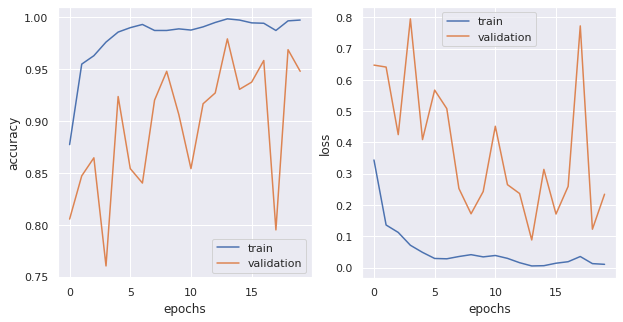

In [17]:
#### training output
sns.set(style='darkgrid')

figure = plt.figure(figsize=(10,5))
ax1 = figure.add_subplot(1, 2, 1)
ax1.plot(history1.history['accuracy'], label='train')
ax1.plot(history1.history['val_accuracy'], label='validation')
ax1.set_xlabel("epochs")
ax1.set_ylabel("accuracy")
ax1.legend()

ax2 = figure.add_subplot(1, 2, 2)
ax2.plot(history1.history['loss'], label='train')
ax2.plot(history1.history['val_loss'], label='validation')
ax2.set_xlabel("epochs")
ax2.set_ylabel("loss")
ax2.legend()

In [18]:
# save the model
model.save('/content/drive/MyDrive/EfficientNetB0_1.h5')
model.save_weights('/content/drive/MyDrive/EfficientNetB0_1_weights.h5')

In [19]:
### see results
y_pred = np.argmax(model.predict(X_test),axis=1)
y_test_new = np.argmax(y_test,axis=1)

13/13 [==============================] - 2s 94ms/step


In [21]:
### classification report
print(classification_report(y_test_new,y_pred))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87       105
           1       1.00      0.31      0.47       100
           2       0.71      0.97      0.82       115
           3       0.99      0.92      0.95        74

    accuracy                           0.80       394
   macro avg       0.86      0.80      0.78       394
weighted avg       0.85      0.80      0.77       394



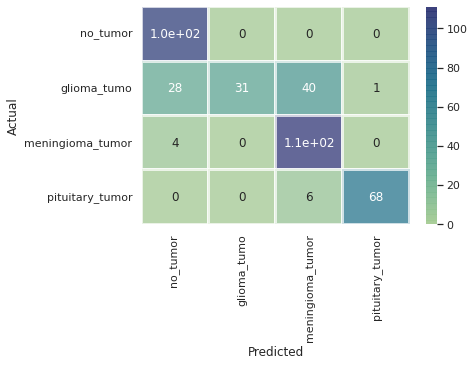

In [22]:
### heatmap of confusion matrix
sns.heatmap(confusion_matrix(y_test_new,y_pred),
            xticklabels=labels,
            yticklabels=labels,
            cmap='crest',
            annot=True,
            alpha=0.7,linewidths=2)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### With cropping

In [5]:
X_train, y_train = load_data_crop(train=True)
X_test, y_test = load_data_crop(train=False)

In [6]:
y_train = np.array([encode_class(y) for y in y_train])
y_train = tf.keras.utils.to_categorical(y_train)
y_test = np.array([encode_class(y) for y in y_test])
y_test = tf.keras.utils.to_categorical(y_test)

In [8]:
# define efficientnet
eff_model = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224,224,3))

model = eff_model.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4, activation="softmax")(model)
model = tf.keras.models.Model(inputs=eff_model.input, outputs=model)

In [9]:
## compile efficientnet model
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [10]:
## fit model on training set
history1 = model.fit(X_train,y_train,validation_split=0.1, 
                      epochs =20, verbose=1, batch_size=32)

Epoch 1/20
81/81 [==============================] - 45s 342ms/step - loss: 0.4191 - accuracy: 0.8413 - val_loss: 6.3233 - val_accuracy: 0.0000e+00
Epoch 2/20
81/81 [==============================] - 25s 308ms/step - loss: 0.1371 - accuracy: 0.9539 - val_loss: 6.3943 - val_accuracy: 0.0000e+00
Epoch 3/20
81/81 [==============================] - 25s 311ms/step - loss: 0.1126 - accuracy: 0.9605 - val_loss: 7.9724 - val_accuracy: 0.0000e+00
Epoch 4/20
81/81 [==============================] - 25s 314ms/step - loss: 0.0587 - accuracy: 0.9806 - val_loss: 6.0040 - val_accuracy: 0.0000e+00
Epoch 5/20
81/81 [==============================] - 25s 312ms/step - loss: 0.0443 - accuracy: 0.9857 - val_loss: 3.9165 - val_accuracy: 0.0000e+00
Epoch 6/20
81/81 [==============================] - 25s 310ms/step - loss: 0.0463 - accuracy: 0.9868 - val_loss: 6.1649 - val_accuracy: 0.0000e+00
Epoch 7/20
81/81 [==============================] - 25s 312ms/step - loss: 0.0482 - accuracy: 0.9845 - val_loss: 1.462

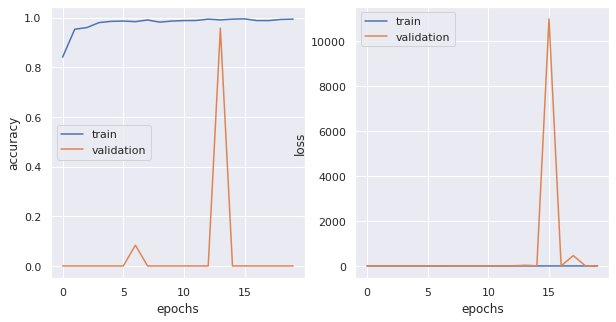

In [13]:
#### training output
sns.set(style='darkgrid')

figure = plt.figure(figsize=(10,5))
ax1 = figure.add_subplot(1, 2, 1)
ax1.plot(history1.history['accuracy'], label='train')
ax1.plot(history1.history['val_accuracy'], label='validation')
ax1.set_xlabel("epochs")
ax1.set_ylabel("accuracy")
ax1.legend()

ax2 = figure.add_subplot(1, 2, 2)
ax2.plot(history1.history['loss'], label='train')
ax2.plot(history1.history['val_loss'], label='validation')
ax2.set_xlabel("epochs")
ax2.set_ylabel("loss")
ax2.legend()

In [14]:
### see results
y_pred = np.argmax(model.predict(X_test),axis=1)
y_test_new = np.argmax(y_test,axis=1)

13/13 [==============================] - 3s 97ms/step


In [16]:
### classification report
print(classification_report(y_test_new,y_pred))

              precision    recall  f1-score   support

           0       0.27      1.00      0.42       105
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       115
           3       0.00      0.00      0.00        74

    accuracy                           0.27       394
   macro avg       0.07      0.25      0.11       394
weighted avg       0.07      0.27      0.11       394



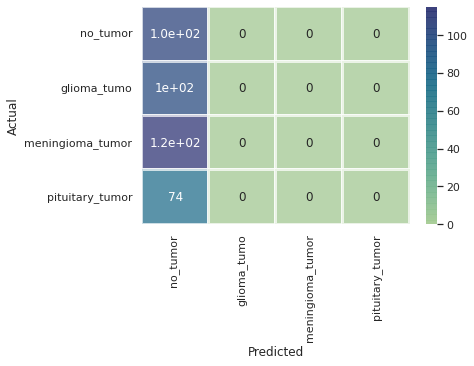

In [17]:
### heatmap of confusion matrix
sns.heatmap(confusion_matrix(y_test_new,y_pred),
            xticklabels=labels,
            yticklabels=labels,
            cmap='crest',
            annot=True,
            alpha=0.7,linewidths=2)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### With data augmentation

In [18]:
### load data
X_train, y_train = load_data(train=True)
X_test, y_test = load_data(train=False)

100%|██████████| 100/100 [00:00<00:00, 200.95it/s]


In [19]:
y_train = np.array([encode_class(y) for y in y_train])
y_train = tf.keras.utils.to_categorical(y_train)
y_test = np.array([encode_class(y) for y in y_test])
y_test = tf.keras.utils.to_categorical(y_test)

In [20]:
X_train, y_train = shuffle(X_train,y_train, random_state=0)

#### data augmentation
# rotate
# shift horizontally and vertically
# zoom in
# flip horizontally 
datagen = ImageDataGenerator(rotation_range=7, 
                              width_shift_range=0.05,
                              height_shift_range=0.05, 
                              zoom_range=0.1, 
                              horizontal_flip=True,
                              validation_split=0.1)

#### split to train and validation
training_gen = datagen.flow(X_train, y_train, batch_size=32, subset='training', seed=0)
validation_gen = datagen.flow(X_train, y_train, batch_size=32, subset='validation', seed=0)

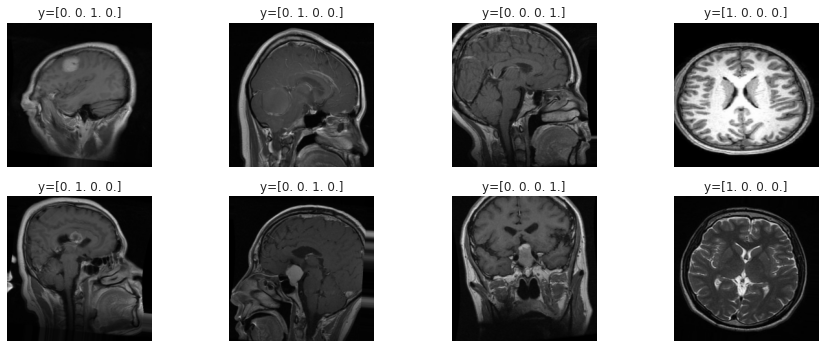

In [21]:
### show augmented data
plt.figure(figsize=(13,5))
for i in range(8):
    plt.subplot(2, 4,i+1)
    for x,y in training_gen:
        plt.imshow((x[0]/255.))
        plt.title('y={}'.format(y[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

In [22]:
# define efficientnet
eff_model = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224,224,3))

model = eff_model.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4, activation="softmax")(model)
model = tf.keras.models.Model(inputs=eff_model.input, outputs=model)

In [23]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [24]:
history2 = model.fit_generator(training_gen,steps_per_epoch=(len(X_train)*0.9)//32, 
                                epochs=20, 
                                validation_data=validation_gen, 
                                validation_steps=(len(X_train)*0.1)//32)

Epoch 1/20
81/81 [==============================] - 46s 457ms/step - loss: 0.4078 - accuracy: 0.8557 - val_loss: 1.3405 - val_accuracy: 0.7153
Epoch 2/20
81/81 [==============================] - 37s 451ms/step - loss: 0.1914 - accuracy: 0.9298 - val_loss: 0.4628 - val_accuracy: 0.8368
Epoch 3/20
81/81 [==============================] - 39s 475ms/step - loss: 0.1203 - accuracy: 0.9618 - val_loss: 0.2067 - val_accuracy: 0.9410
Epoch 4/20
81/81 [==============================] - 36s 438ms/step - loss: 0.1045 - accuracy: 0.9622 - val_loss: 0.1106 - val_accuracy: 0.9514
Epoch 5/20
81/81 [==============================] - 36s 445ms/step - loss: 0.0993 - accuracy: 0.9630 - val_loss: 0.1868 - val_accuracy: 0.9514
Epoch 6/20
81/81 [==============================] - 37s 450ms/step - loss: 0.0783 - accuracy: 0.9715 - val_loss: 0.1291 - val_accuracy: 0.9722
Epoch 7/20
81/81 [==============================] - 36s 438ms/step - loss: 0.0863 - accuracy: 0.9780 - val_loss: 0.1483 - val_accuracy: 0.9583

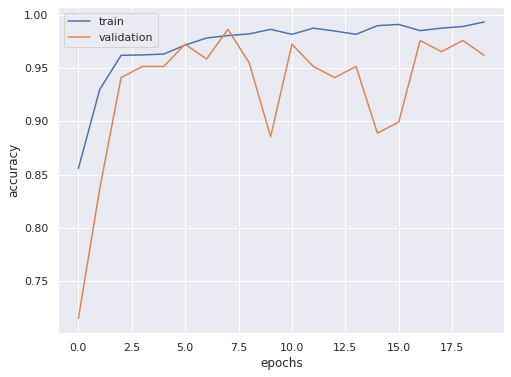

In [25]:
#### training output
figure = plt.figure(figsize=(8,6))
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

In [26]:
#### performance on test set
y_pred = np.argmax(model.predict(X_test),axis=1)
y_test_new = np.argmax(y_test,axis=1)

13/13 [==============================] - 3s 58ms/step


In [27]:
print(classification_report(y_test_new,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.99      0.86       105
           1       1.00      0.32      0.48       100
           2       0.72      0.97      0.82       115
           3       0.94      0.91      0.92        74

    accuracy                           0.80       394
   macro avg       0.86      0.80      0.77       394
weighted avg       0.84      0.80      0.77       394



#### K-Means with transfer learning

Our best obtained model is EfficientNet without data-augmentation / cropping. We will use the saved model to assist K-means clustering.

In [28]:
#### load saved model
model = load_model("/content/drive/MyDrive/EfficientNetB0_1.h5")

In [29]:
def extract_features(X, model):

    effnet_feature_list = []

    for img in X:

        effnet_feature = model.predict(np.expand_dims(img.copy(), axis=0))

        effnet_feature_np = np.array(effnet_feature)

        effnet_feature_list.append(effnet_feature_np.flatten())
    
    return np.array(effnet_feature_list)

In [39]:
# extract predicted features
feature_array = extract_features(X_test, model)

1/1 [==============================] - 0s 27ms/step


In [40]:
#### initiate K-means model
kmeans = KMeans(n_clusters=4, random_state=0)

#### fit and predict
clusters = kmeans.fit_predict(feature_array)

In [44]:
##### match clustering results with actual labels

# /***************************************************************************************
# *    Title: match_label and get_labels source code
# *    Author: OSIRIS
# *    Date: Jun 23 2021
# *    Code version: 3.0
# *    Availability: https://github.com/r-sajal/DeepLearning-/blob/master/ComputerVision/k-means-blog-tutorial.ipynb
# *
# ***************************************************************************************/

def match_label(clusters,data_label):
    label = {}
    
    for i in range(len(np.unique(clusters))): # for each cluster in our clustering 
        index = np.where(clusters == i,1,0)
        n = np.bincount(data_label[index==1]).argmax()
        label[i] = n
    return label

def get_labels(clusters,reference_labels):
    temp_labels = np.random.rand(len(clusters))
    for i in range(len(clusters)):
        temp_labels[i] = reference_labels[clusters[i]]
    return temp_labels

In [41]:
data_label = []
for i in range(len(y_test)):
  data_label += list(np.where(y_test[i] == 1)[0])
data_label = np.array(data_label)

In [45]:
reference_labels = match_label(clusters,data_label)
predicted_labels = get_labels(clusters,reference_labels)

In [47]:
#### model performance 
print(accuracy_score(predicted_labels, data_label
))

0.8020304568527918


In [46]:
##### check performance
print(classification_report(data_label, predicted_labels))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87       105
           1       1.00      0.32      0.48       100
           2       0.71      0.97      0.82       115
           3       0.99      0.92      0.95        74

    accuracy                           0.80       394
   macro avg       0.87      0.80      0.78       394
weighted avg       0.85      0.80      0.77       394



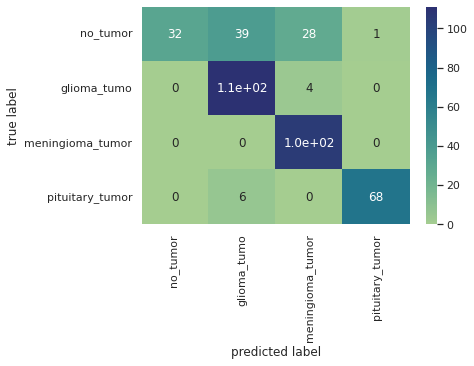

In [48]:
##### confusion matrix

mat = confusion_matrix(np.array([int_to_label(x) for x in data_label]),
                       np.array([int_to_label(x) for x in predicted_labels]))

sns.heatmap(mat, annot=True, xticklabels=labels,
            yticklabels=labels, cmap='crest')

plt.ylabel('true label')
plt.xlabel('predicted label')
plt.show()